# Appriximate MPC with CSTR

In this Jupyter Notebook we illustrate the example **Appriximate MPC with CSTR**.

**Open an interactive online Jupyter Notebook with this content on Binder:**

[![Binder](https://mybinder.org/badge_logo.svg)]()

The example consists of the three modules **template_model.py**, which describes the system model, **template_mpc.py**, which defines the settings for the control and **template_simulator.py**, which sets the parameters for the simulator.
The modules are used in **main.py** for the closed-loop execution of the controller.

In the following the different parts are presented. But first, we start by importing basic modules and **do-mpc**.

In [ ]:
from casadi.tools import *
import sys
import os

# Add do_mpc to path. This is not necessary if it was installed via pip
rel_do_mpc_path = os.path.join('..', '..', '..')
sys.path.append(rel_do_mpc_path)

# Import do_mpc package:
import do_mpc


import matplotlib.pyplot as plt

## Model

In the following we will present the configuration, setup and connection between these blocks, starting with the `model`.
The considered model of the CSTR is continuous and has 4 states and 2 control inputs.
The model is initiated by:

In [6]:
model_type = 'continuous' # either 'discrete' or 'continuous'
model = do_mpc.model.Model(model_type)

### States and control inputs

The four states are concentration of reactant A ($C_{\text{A}}$), the concentration of reactant B ($C_{\text{B}}$), the temperature inside the reactor ($T_{\text{R}}$) and the temperature of the cooling jacket ($T_{\text{K}}$):

In [7]:
# States struct (optimization variables):
C_a = model.set_variable(var_type='_x', var_name='C_a', shape=(1,1))
C_b = model.set_variable(var_type='_x', var_name='C_b', shape=(1,1))
T_R = model.set_variable(var_type='_x', var_name='T_R', shape=(1,1))
T_K = model.set_variable(var_type='_x', var_name='T_K', shape=(1,1))

The control inputs are the feed $F$ and the heat flow $\dot{Q}$:

In [8]:
# Input struct (optimization variables):
F = model.set_variable(var_type='_u', var_name='F')
Q_dot = model.set_variable(var_type='_u', var_name='Q_dot')

### ODE and parameters

The system model is described by the ordinary differential equation:

\begin{align}
\dot{C}_{\text{A}} &= F \cdot (C_{\text{A},0} - C_{\text{A}}) - k_1 \cdot C_{\text{A}} - k_3 \cdot C_{\text{A}}^2, \\
\dot{C}_{\text{B}} &= -F \cdot C_{\text{B}} + k_1 \cdot C_{\text{A}} - k_2 \cdot C_{\text{B}}, \\
\dot{T}_{\text{R}} &= \frac{k_1 \cdot C_{\text{A}} \cdot H_{\text{R},ab} + k_2 \cdot C_{\text{B}} \cdot  H_{\text{R},bc} + k_3 \cdot C_{\text{A}}^2 \cdot H_{\text{R},ad}} {-\rho \cdot c_p}\\
&+ F \cdot (T_{\text{in}} - T_{\text{R}}) + \frac{K_w \cdot A_{\text{R}} \cdot(T_{\text{K}}-T_{\text{R}})}{\rho \cdot c_p \cdot V_{\text{R}}}, \\
\dot{T}_{\text{K}} &= \frac{\dot{Q} + K_w \cdot A_{\text{R}} \cdot T_{\text{dif}}}{m_k \cdot C_{p,k}},
\end{align}

where

\begin{align}
k_1 &= \beta \cdot k_{0,\text{ab}} \cdot \exp\left(\frac{-E_{\text{A},\text{ab}}}{T_{\text{R}}+273.15}\right), \\
k_2 &= k_{0,\text{bc}} \cdot \exp \left( \frac{-E_{\text{A},\text{bc}}}{T_{\text{R}}+273.15} \right), \\
k_3 &= k_{0,\text{ad}} \cdot \exp \left( \frac{-\alpha \cdot E_{\text{A},\text{ad}}}{T_{\text{R}}+273.15} \right).
\end{align}

In [9]:
# Certain parameters
K0_ab = 1.287e12 # K0 [h^-1]
K0_bc = 1.287e12 # K0 [h^-1]
K0_ad = 9.043e9 # K0 [l/mol.h]
R_gas = 8.3144621e-3 # Universal gas constant
E_A_ab = 9758.3*1.00 #* R_gas# [kj/mol]
E_A_bc = 9758.3*1.00 #* R_gas# [kj/mol]
E_A_ad = 8560.0*1.0 #* R_gas# [kj/mol]
H_R_ab = 4.2 # [kj/mol A]
H_R_bc = -11.0 # [kj/mol B] Exothermic
H_R_ad = -41.85 # [kj/mol A] Exothermic
Rou = 0.9342 # Density [kg/l]
Cp = 3.01 # Specific Heat capacity [kj/Kg.K]
Cp_k = 2.0 # Coolant heat capacity [kj/kg.k]
A_R = 0.215 # Area of reactor wall [m^2]
V_R = 10.01 #0.01 # Volume of reactor [l]
m_k = 5.0 # Coolant mass[kg]
T_in = 130.0 # Temp of inflow [Celsius]
K_w = 4032.0 # [kj/h.m^2.K]
C_A0 = (5.7+4.5)/2.0*1.0 # Concentration of A in input Upper bound 5.7 lower bound 4.5 [mol/l]
alpha=1
beta=1


In the next step, we formulate the $k_i$-s:

In [10]:
# Auxiliary terms
K_1 = beta * K0_ab * exp((-E_A_ab)/((T_R+273.15)))
K_2 =  K0_bc * exp((-E_A_bc)/((T_R+273.15)))
K_3 = K0_ad * exp((-alpha*E_A_ad)/((T_R+273.15)))

Additionally, we define an artificial variable of interest, that is not a state of the system, but will be later used for plotting:

In [11]:
T_dif = model.set_expression(expr_name='T_dif', expr=T_R-T_K)

WIth the help ot the $k_i$-s and $T_{\text{dif}}$ we can define the ODEs:

In [12]:
model.set_rhs('C_a', F*(C_A0 - C_a) -K_1*C_a - K_3*(C_a**2))
model.set_rhs('C_b', -F*C_b + K_1*C_a - K_2*C_b)
model.set_rhs('T_R', ((K_1*C_a*H_R_ab + K_2*C_b*H_R_bc + K_3*(C_a**2)*H_R_ad)/(-Rou*Cp)) + F*(T_in-T_R) +(((K_w*A_R)*(-T_dif))/(Rou*Cp*V_R)))
model.set_rhs('T_K', (Q_dot + K_w*A_R*(T_dif))/(m_k*Cp_k))

Finally, the model setup is completed:

In [13]:
# Build the model
model.setup()

## Controller

Next, the model predictive controller is configured.
First, one member of the mpc class is generated with the prediction model defined above:

In [14]:
mpc = do_mpc.controller.MPC(model)

We choose the prediction horizon `n_horizon`, set the robust horizon `n_robust` to 1. The time step `t_step` is set to one second and parameters of the applied discretization scheme orthogonal collocation are as seen below:

In [15]:
# Set settings of MPC:
mpc.settings.n_horizon = 20
mpc.settings.n_robust = 0
mpc.settings.open_loop = 0
mpc.settings.t_step = 0.005
mpc.settings.state_discretization = 'collocation'
mpc.settings.collocation_type = 'radau'
mpc.settings.collocation_deg = 2
mpc.settings.collocation_ni = 1
mpc.settings.store_full_solution = True

Because the magnitude of the states and inputs is very different, we introduce scaling factors:

In [16]:
mpc.scaling['_x', 'T_R'] = 100
mpc.scaling['_x', 'T_K'] = 100
mpc.scaling['_u', 'Q_dot'] = 2000
mpc.scaling['_u', 'F'] = 100

### Objective

The goal of the CSTR is to obtain a mixture with a concentration of $C_{\text{B,ref}} = 0.6$ mol/l.
Additionally, we add a penalty on input changes for both control inputs, to obtain a smooth control performance.

In [17]:
mterm = (model.x['C_b'] - 0.6)**2+(model.x['C_a'] - 0.7)**2
lterm = (model.x['C_b'] - 0.6)**2+(model.x['C_a'] - 0.7)**2

mpc.set_objective(mterm=mterm, lterm=lterm)

mpc.set_rterm(F=0.1, Q_dot = 1e-3)

### Constraints

In the next step, the constraints of the control problem are set.
In this case, there are only upper and lower bounds for each state and the input:

In [18]:
# lower bounds of the states
mpc.bounds['lower', '_x', 'C_a'] = 0.1
mpc.bounds['lower', '_x', 'C_b'] = 0.1
mpc.bounds['lower', '_x', 'T_R'] = 50
mpc.bounds['lower', '_x', 'T_K'] = 50

# upper bounds of the states
mpc.bounds['upper', '_x', 'C_a'] = 2
mpc.bounds['upper', '_x', 'C_b'] = 2
mpc.bounds['upper', '_x', 'T_R'] = 140
mpc.bounds['upper', '_x', 'T_K'] = 140

# lower bounds of the inputs
mpc.bounds['lower', '_u', 'F'] = 5
mpc.bounds['lower', '_u', 'Q_dot'] = -8500

# upper bounds of the inputs
mpc.bounds['upper', '_u', 'F'] = 100
mpc.bounds['upper', '_u', 'Q_dot'] = 0.0

The setup of the MPC controller is concluded by:

In [19]:
mpc.setup()

## Estimator

We assume, that all states can be directly measured (state-feedback):

In [20]:
estimator = do_mpc.estimator.StateFeedback(model)

## Simulator

To create a simulator in order to run the MPC in a closed-loop, we create an instance of the **do-mpc** simulator which is based on the same model:

In [21]:
simulator = do_mpc.simulator.Simulator(model)

For the simulation, we use the same time step `t_step` as for the optimizer:

In [22]:
params_simulator = {
        'integration_tool': 'cvodes',
        'abstol': 1e-10,
        'reltol': 1e-10,
        't_step': 0.005
    }

simulator.set_param(**params_simulator)

To finish the configuration of the simulator, call:

In [23]:
simulator.setup()

## Initilisation

For the initilisation of the MPC configured for the CSTR, we inspect the file **main.py**.
We define the initial state of the system and set it for all parts of the closed-loop configuration:

In [24]:
# Set the initial state of mpc and simulator:
C_a_0 = 0.8 # This is the initial concentration inside the tank [mol/l]
C_b_0 = 0.5 # This is the controlled variable [mol/l]
T_R_0 = 134.14 #[C]
T_K_0 = 130.0 #[C]
x0 = np.array([C_a_0, C_b_0, T_R_0, T_K_0]).reshape(-1,1)
u0=np.array([[5],[0]])

# pushing to class
mpc.x0 = x0
simulator.x0 = x0
mpc.set_initial_guess()
simulator.set_initial_guess()

## Approximate MPC

Next, the Approximate MPC is configured. First, one member of the ApproximateMPC class is generated with the prediction model defined above:

In [25]:
approx_mpc = do_mpc.approximateMPC.ApproxMPC(mpc)

Appropriate sizes for number of hidden layers `n_hidden_layers` and number of neurons per layer `n_neurons` is chosen:

In [26]:
approx_mpc.settings.n_hidden_layers = 3
approx_mpc.settings.n_neurons = 50

The setup of the Approximate MPC controller is concluded by:

In [27]:
approx_mpc.setup()

----------------------------------
ApproxMPC(
  (net): FeedforwardNN(
    (layers): ModuleList(
      (0): Linear(in_features=6, out_features=50, bias=True)
      (1): ReLU()
      (2): Linear(in_features=50, out_features=50, bias=True)
      (3): ReLU()
      (4): Linear(in_features=50, out_features=50, bias=True)
      (5): ReLU()
      (6): Linear(in_features=50, out_features=2, bias=True)
    )
  )
)
----------------------------------


## Sampler

Next, a Sampler is configured. This class is generated with the above MPC class, to train the Approximate MPC. This class generates the optimal inputs given by randomly generated states.

In [28]:
sampler = do_mpc.approximateMPC.Sampler(mpc)

Sampler settings are configured. The `closed_loop_flag` is used to simulate the closed loop trajecoires along with the open loop trajectories to get a better guess at the optimal input. For the same `trajectory_length` is set to `5`.

In [29]:
sampler.settings.closed_loop_flag = True
sampler.settings.trajectory_length = 10

To generate the sampled data, number of samples to be simulated must also be provided by `n_samples`.

In [30]:
sampler.settings.n_samples = 10000

A location is being setup with `data_dir` where the sampled data will be stored for furthuer use.

In [31]:
sampler.settings.data_dir = './sampled_data_notebook'

The setup of the Sampler class is concluded by:

In [32]:
sampler.setup()

The Sampler is now used to generate the sample data on which the ApproximateMPC will be trained further. for this a default sumpling plan is used. This iteratively calculates the training data, so depending on `n_samples` and the complexity of the MPC controller, it might take a while. (The output of the MPC is supperssed with the magic command `%%capture`)

In [33]:
%%capture
sampler.default_sampling()

## Trainer

Next, a Trainer is configured. This class is generated with the above Approximate MPC class, is used to train the same.

In [34]:
trainer = do_mpc.approximateMPC.Trainer(approx_mpc)

Next the trainer settings is configured:

In [35]:
trainer.settings.n_samples = 10000
trainer.settings.n_epochs = 1000
trainer.settings.scheduler_flag = True

Since `scheduler_flag` is set to `True`, we can change a few other settings for the Scheduler as shown below:

In [36]:
trainer.scheduler_settings.cooldown = 0
trainer.scheduler_settings.patience = 10

To display and save the performance of the training, the following flags may be set:

In [37]:
trainer.settings.show_fig =True
trainer.settings.save_fig = True
trainer.settings.save_history = True

The loaction where the samples data is stored is provided with `data_dir`:

In [38]:
trainer.settings.data_dir = './sampled_data_notebook'

Finally, the trainer is setup:

In [39]:
trainer.setup()

The training process is initiated:

Path from trainer to sampled files
 sampled_data_notebook\data_n10000_opt.pkl


c:\Users\naska\anaconda3\envs\appx_mpc\Lib\site-packages\torch\utils\_device.py:106: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  return func(*args, **kwargs)


epoch :  9
train_loss :  0.0005034646109296855
val_loss :  0.0004437170365625726
-------------------------------
epoch :  19
train_loss :  0.0002951313287749971
val_loss :  0.0002970708446810022
-------------------------------
epoch :  29
train_loss :  0.0002441216568430801
val_loss :  0.0002364906551000396
-------------------------------
epoch :  39
train_loss :  0.00020483243365147658
val_loss :  0.00022574499442790902
-------------------------------
epoch :  49
train_loss :  0.0001739667069738392
val_loss :  0.00018750272231825096
-------------------------------
epoch :  59
train_loss :  0.00015956467905198224
val_loss :  0.00014827554540326155
-------------------------------
epoch :  69
train_loss :  0.00013965630112745036
val_loss :  0.00011784660507276255
-------------------------------
epoch :  79
train_loss :  0.00012304380652494729
val_loss :  0.00011087572732191932
-------------------------------
epoch :  89
train_loss :  9.106471479753963e-05
val_loss :  0.000107065840243844

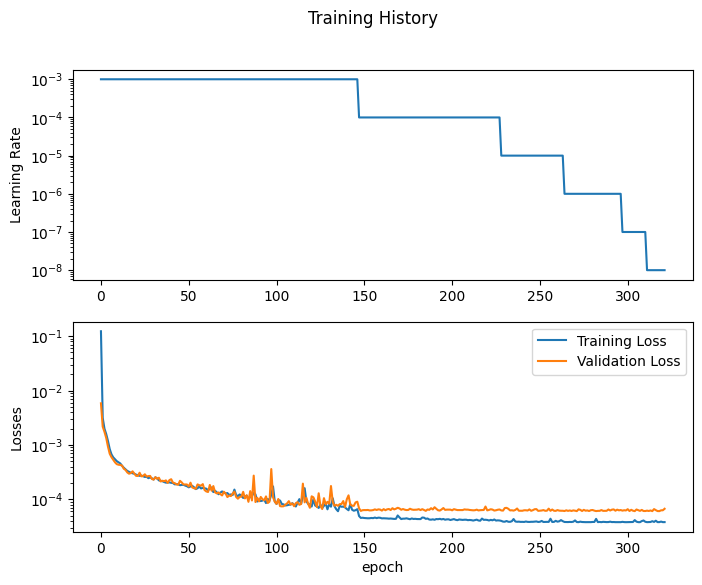

In [40]:
trainer.default_training()

# Closed loop simulation

Now all we are ready for simulating the system with the newly trained Approximate MPC controller, for 50 steps.

In [41]:
sim_time = 50
for k in range(sim_time):
    u0 = approx_mpc.make_step(x0, clip_to_bounds=False)
    y_next = simulator.make_step(u0)
    x0 = estimator.make_step(y_next)

## Animating the results

To animate the results, we first configure the **do-mpc** graphics object, which is initiated with the respective data object:

In [42]:
sim_graphics = do_mpc.graphics.Graphics(simulator.data)

We then create a figure, configure which lines to plot on which axis and add labels.

Text(0.5, 0, 'time [h]')

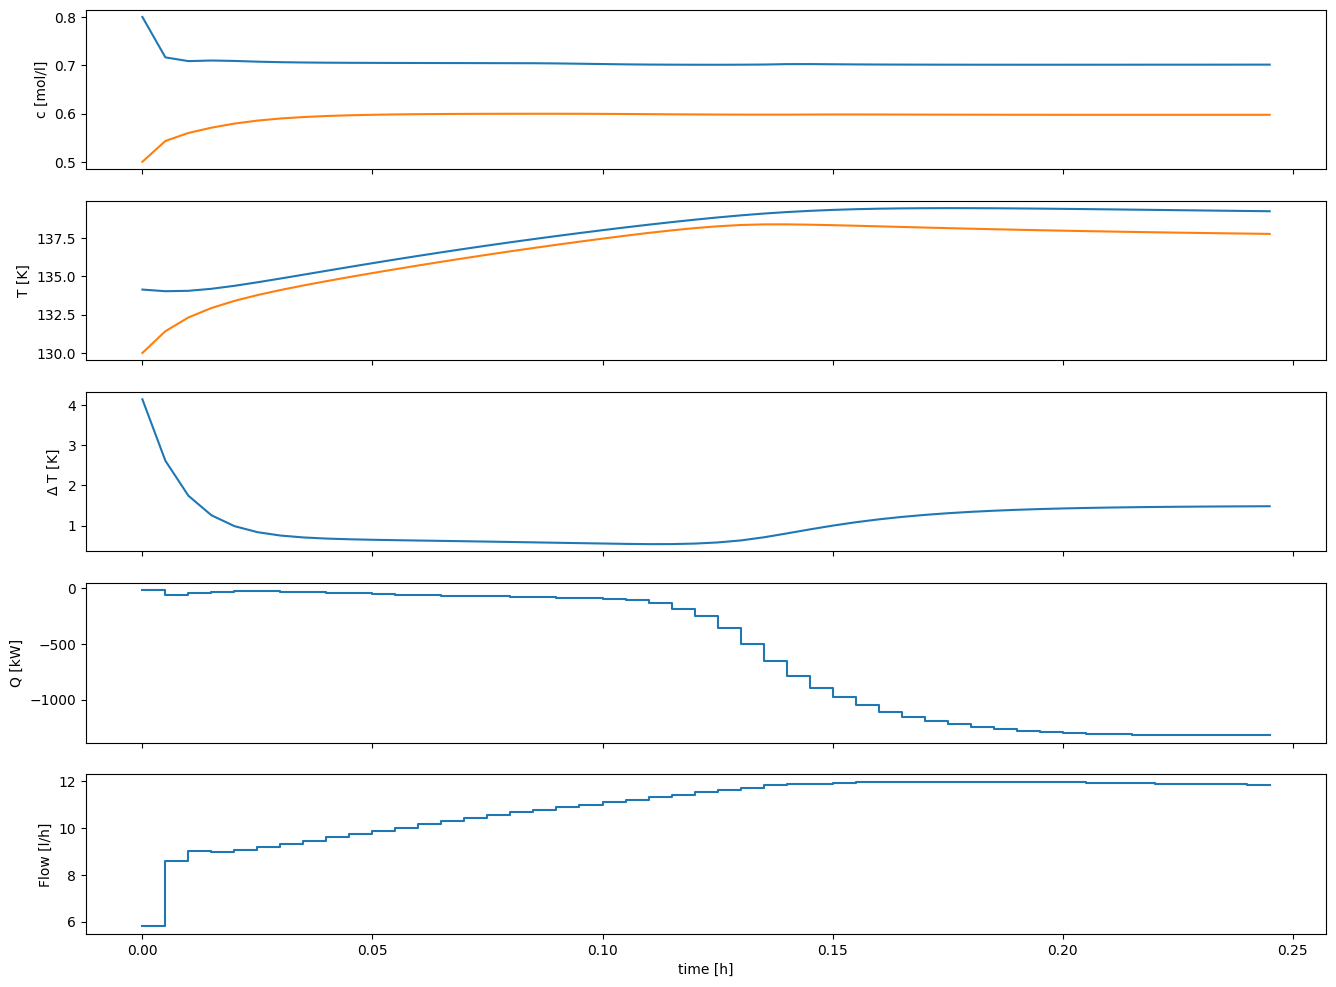

In [43]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(5, sharex=True, figsize=(16,12))
# Configure plot:
sim_graphics.add_line(var_type='_x', var_name='C_a', axis=ax[0])
sim_graphics.add_line(var_type='_x', var_name='C_b', axis=ax[0])
sim_graphics.add_line(var_type='_x', var_name='T_R', axis=ax[1])
sim_graphics.add_line(var_type='_x', var_name='T_K', axis=ax[1])
sim_graphics.add_line(var_type='_aux', var_name='T_dif', axis=ax[2])
sim_graphics.add_line(var_type='_u', var_name='Q_dot', axis=ax[3])
sim_graphics.add_line(var_type='_u', var_name='F', axis=ax[4])
ax[0].set_ylabel('c [mol/l]')
ax[1].set_ylabel('T [K]')
ax[2].set_ylabel('$\Delta$ T [K]')
ax[3].set_ylabel('Q [kW]')
ax[4].set_ylabel('Flow [l/h]')
ax[4].set_xlabel('time [h]')

Some "cosmetic" modifications are easily achieved with the structure ``result_lines``.

In [44]:
# Add labels
label_lines = sim_graphics.result_lines['_x', 'C_a']+sim_graphics.result_lines['_x', 'C_b']
ax[0].legend(label_lines, ['C_a', 'C_b'])
label_lines = sim_graphics.result_lines['_x', 'T_R']+sim_graphics.result_lines['_x', 'T_K']
ax[1].legend(label_lines, ['T_R', 'T_K'])

fig.align_ylabels()

After importing the necessary package:

In [45]:
from matplotlib.animation import FuncAnimation, ImageMagickWriter

We obtain the animation with:

In [46]:
def update(t_ind):
    print('Writing frame: {}.'.format(t_ind), end='\r')
    sim_graphics.plot_results(t_ind=t_ind)
    #sim_graphics.plot_predictions(t_ind=t_ind)
    sim_graphics.reset_axes()
    lines = sim_graphics.result_lines.full
    return lines

n_steps = sim_graphics.data['_time'].shape[0]


anim = FuncAnimation(fig, update, frames=n_steps, blit=True)

gif_writer = ImageMagickWriter(fps=5)
anim.save('anim_appxCSTR_nb.gif', writer=gif_writer)

![cstranim](anim_appx_CSTR_10000_closed.gif "cstr")